# Using MCMC

pyMechT can be used to run Markov Chain Monte Carlo (MCMC) simulation using the `MCMC` module as demonstrated in this example. We start by creating an experiment sample that will be used in the simulation.

In [17]:
import pymecht as pmt
import numpy as np
import matplotlib.pyplot as plt
mat = pmt.MatModel('nh')
sample = pmt.UniaxialExtension(mat, force_measure='force')
params = sample.parameters

params.fix('A0',10)
params.set('mu_0',10)
params.set_lb('L0',0.1)
params.set_ub('L0',3)
#params.fix('L0')

Next, we assume some observations and a simulation function that tries to reproduce the observations given the parameter values. This part is similar to the classical fitting, as seen in the `ParamFitter` example. However, there are two key differences:

- The observations have an error structure, with respect to which we match the simulation outcome to obtain a likelihood
- The simulation function must return a tuple of the likelihood and the simulation results (instead of just the simulation result being returned for classical parameter fitting)

In [2]:
applied_stretch = np.linspace(1,1.3,10)
force_measured = np.array([0,9,21,29,40,49,58,65,75,84])

def prob(params):
    force_modeled = sample.disp_controlled(applied_stretch,params)
    diff = force_modeled - force_measured
    diff_norm2 = np.dot(diff,diff)
    var = 5
    prob = np.exp(-diff_norm2/2./var) #in the case of MCMC we can skip the proportionality factor
    return prob,force_modeled


In the above example, we are modeling the likelihood to be Gaussian, $p(x | \theta ) \propto \exp\left( \frac{\|x-\mu\|^2}{2\sigma^2} \right)$ where $x$ is the modeled force, $\mu$ is the (mean) measured force, $\|x-\mu\|^2$ is the norm of the difference between modeled and observed forces, and $\sigma^2$ is the variance of the error in the measured force, chosen to be $\sigma^2=5$ here. When we set the `MCMC` instance with this function, it is set to vary all three parameters involved. 

In [3]:
mcmc = pmt.MCMC(prob,params)

MCMC instance created with the following settings
------------------------------------------------------------------
Keys              Value       Fixed?      Lower bound Upper bound 
------------------------------------------------------------------
L0                1.00        No          0.10        3.00        
A0                10.00       Yes         -           -           
mu_0              10.00       No          1.00e-04    1.00e+02    
------------------------------------------------------------------

2 parameters will be varied.


With the `MCMC` instance created, we can run the simulation for any chosen number of iterations, say $n$ . During the simulation, candidate samples are generated between the lower/upper bounds based on a proposal density function. Here, the proposal density function is also a Gaussian distribution centered at the current value and a diagonal covariance matrix, whose enteries can be viewed/set using `.std`.

In [4]:
print(mcmc.std)

[0.145    4.999995]


By default, these are chosen to be 5% of the range of each parameter. We can set them as follows:

In [5]:
mcmc.std = np.array([1, 1])
print(mcmc.std)

[1 1]


The choice of this can be practically important to how many samples get accepted/rejected. Finally, we can run for say 100,000 iterations.

In [6]:
mcmc.run(100000)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:29<00:00, 3349.89it/s]

MCMC sampling completed. Acceptance rate: 0.14412
Number of samples: 14412
To access the samples, use get_samples_pandas()


The number of generated samples will be always lower than the number of iterations and will vary from simulation to simulation due to its stochastic nature. As per the theory behind MCMC, there is an initial burn-out period, and we need to discard those. Assume the burn-out period is the first 4000 samples, so we discard those, and we only calculate the summary stastistics on the rest.

In [7]:
gen_samples = mcmc.get_samples_pandas()[4000:]
print(gen_samples.shape)
print('Mean parameters:\n', gen_samples.mean())

(10412, 3)
Mean parameters:
 L0       1.582872
A0      10.000000
mu_0    11.506687
dtype: float64


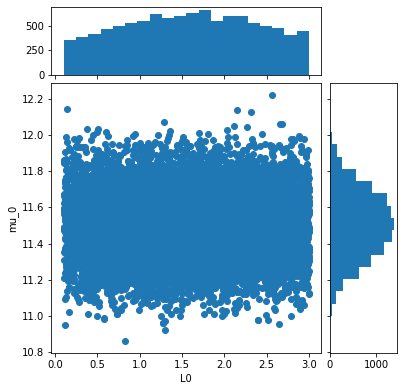

In [8]:
def scatter_hist(x, y, ax, ax_histx, ax_histy):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    ax.scatter(x, y)
    ax_histx.hist(x, bins=20)
    ax_histy.hist(y, bins=20, orientation='horizontal')

# Start with a square Figure.
fig = plt.figure(figsize=(6, 6))
# Add a gridspec with two rows and two columns and a ratio of 1 to 4 between
# the size of the marginal Axes and the main Axes in both directions.
# Also adjust the subplot parameters for a square plot.
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)
# Create the Axes.
ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
# Draw the scatter plot and marginals.
scatter_hist(gen_samples['L0'].to_numpy(), gen_samples['mu_0'].to_numpy(), ax, ax_histx, ax_histy)
ax.set_xlabel('L0')
ax.set_ylabel('mu_0')
plt.show()

The resulting distribution of L0 is close to uniform, since its value is not relevant to the observed force under specified stretch. On the other hand, we get an approximately Gaussian distribution of the stiffness parameter mu_0.

## Getting values and probs

In addition to the samples, we can also get the results of the simulations and their probabilities (likelihoods) using `get_values()` and `get_probs()` methods, respectively. These both return lists too. The MCMC generates independently and identically distributed (i.i.d.) samples. Thus, we can plot summary statistics on the simulation results and probabilities. Similar to the samples, we also remove the initial ones as a burn-out period.

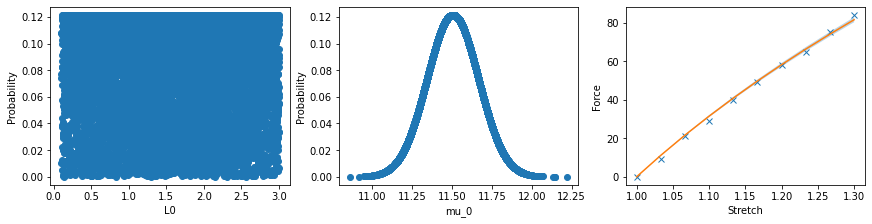

In [9]:
mcmc_probs = np.array(mcmc.get_probs()[4000:]) #convert the list into an array
mcmc_force = np.array(mcmc.get_values()[4000:]) #convert the list into an array
mean = np.mean(mcmc_force,axis=0)
sd = np.std(mcmc_force,axis=0)

fig, ax = plt.subplots(1,3,figsize=(12,3),layout='constrained')
ax[0].scatter(gen_samples['L0'].to_numpy(),mcmc_probs)
ax[0].set_xlabel('L0')
ax[0].set_ylabel('Probability')
ax[1].scatter(gen_samples['mu_0'].to_numpy(),mcmc_probs)
ax[1].set_xlabel('mu_0')
ax[1].set_ylabel('Probability')
ax[2].plot(applied_stretch,force_measured,'x')
ax[2].plot(applied_stretch,mean,'-')
ax[2].fill_between(applied_stretch,mean-sd,mean+sd,alpha=0.3)
ax[2].set_xlabel('Stretch')
ax[2].set_ylabel('Force')
plt.show()

## Correlated parameters

If we run a different version of the above problem, where the two parameters are correlated, we see how that is captured. For example, what happens if the length of the sample is fixed, and the cross-section area is varied instead?

In [10]:
mat = pmt.MatModel('nh')
sample = pmt.UniaxialExtension(mat, force_measure='force')
params = sample.parameters

params.set('A0',10)
params.set('mu_0',10)
params.fix('L0')

mcmc = pmt.MCMC(prob,params)
mcmc.std = np.array([1, 1])

mcmc.run(100000)

MCMC instance created with the following settings
------------------------------------------------------------------
Keys              Value       Fixed?      Lower bound Upper bound 
------------------------------------------------------------------
L0                1.00        Yes         -           -           
A0                10.00       No          1.00e-04    1.00e+03    
mu_0              10.00       No          1.00e-04    1.00e+02    
------------------------------------------------------------------

2 parameters will be varied.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:39<00:00, 2500.56it/s]

MCMC sampling completed. Acceptance rate: 0.07231
Number of samples: 7231
To access the samples, use get_samples_pandas()


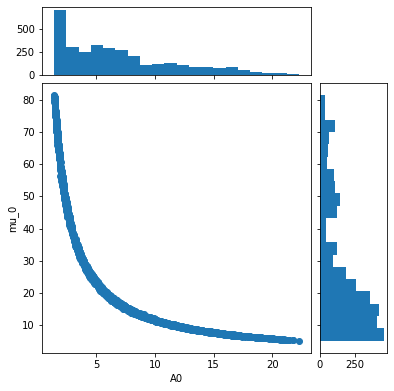

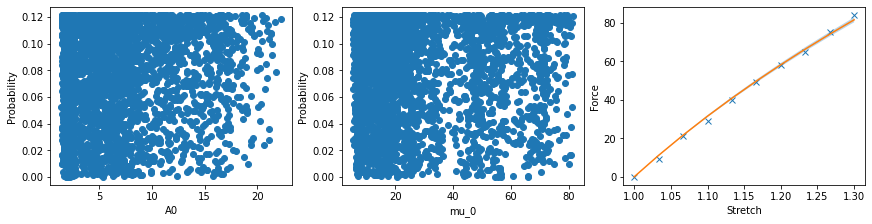

In [11]:
gen_samples = mcmc.get_samples_pandas()[4000:]
mcmc_probs = np.array(mcmc.get_probs()[4000:]) #convert the list into an array
mcmc_force = np.array(mcmc.get_values()[4000:]) #convert the list into an array
mean = np.mean(mcmc_force,axis=0)
sd = np.std(mcmc_force,axis=0)

# Start with a square Figure.
fig = plt.figure(figsize=(6, 6))
# Add a gridspec with two rows and two columns and a ratio of 1 to 4 between
# the size of the marginal Axes and the main Axes in both directions.
# Also adjust the subplot parameters for a square plot.
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)
# Create the Axes.
ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
# Draw the scatter plot and marginals.
scatter_hist(gen_samples['A0'].to_numpy(), gen_samples['mu_0'].to_numpy(), ax, ax_histx, ax_histy)
ax.set_xlabel('A0')
ax.set_ylabel('mu_0')
plt.show()

fig, ax = plt.subplots(1,3,figsize=(12,3),layout='constrained')
ax[0].scatter(gen_samples['A0'].to_numpy(),mcmc_probs)
ax[0].set_xlabel('A0')
ax[0].set_ylabel('Probability')
ax[1].scatter(gen_samples['mu_0'].to_numpy(),mcmc_probs)
ax[1].set_xlabel('mu_0')
ax[1].set_ylabel('Probability')
ax[2].plot(applied_stretch,force_measured,'x')
ax[2].plot(applied_stretch,mean,'-')
ax[2].fill_between(applied_stretch,mean-sd,mean+sd,alpha=0.3)
ax[2].set_xlabel('Stretch')
ax[2].set_ylabel('Force')
plt.show()

In this case, the two parameters are perfectly correlated since it is their product $A_0\mu$ that appears in the force expression, and the resulting scatter plot closely follows a hyperbola. In other words, we can have either high area and small stiffness or low area and high stiffness to give the same result. Therefore, the resulting stretch-force curve is still similar to the previous case.

## Assigning prior probability

In the above example, while we had lower/upper bounds, the parameters had uniform prior probability within these. As a result, in the probability expression there was no prior term. However, this can be included. For example, if we assume that before the expriment, the stiffness mu_0 is Gaussian with mean 5 and variance 1, we can modify the probability function accordingly and re-run the MCMC simulation, as follows.

In [12]:
mat = pmt.MatModel('nh')
sample = pmt.UniaxialExtension(mat, force_measure='force')
params = sample.parameters
params.fix('A0',10)
params.fix('L0',1)

def prob_w_prior(params):
    force_modeled = sample.disp_controlled(applied_stretch,params)
    diff = force_modeled - force_measured
    diff_norm2 = np.dot(diff,diff)
    var = 5
    mu_val = params['mu_0']
    mu_mean = 5
    mu_var = 1
    prior = np.exp(-(mu_val-mu_mean)**2/2/mu_var)
    prob = np.exp(-diff_norm2/2./var)*prior #in the case of MCMC we can skip the proportionality factor
    return prob,force_modeled

mcmc = pmt.MCMC(prob_w_prior,params)
mcmc.std = np.array([1])

mcmc.run(100000)

MCMC instance created with the following settings
------------------------------------------------------------------
Keys              Value       Fixed?      Lower bound Upper bound 
------------------------------------------------------------------
L0                1.00        Yes         -           -           
A0                10.00       Yes         -           -           
mu_0              1.00        No          1.00e-04    1.00e+02    
------------------------------------------------------------------

1 parameters will be varied.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:40<00:00, 2468.32it/s]

MCMC sampling completed. Acceptance rate: 0.19684
Number of samples: 19684
To access the samples, use get_samples_pandas()


In [13]:
gen_samples = mcmc.get_samples_pandas()[4000:]
print('Mean parameters:\n', gen_samples.mean())

Mean parameters:
 L0       1.000000
A0      10.000000
mu_0    11.342178
dtype: float64


Due to the prior, the posterior mean has shifted down from approximately 11.5 to approximate 11.34